In [1]:
import tempfile
import os
from subprocess import call
import matplotlib.pyplot as plt
from f90nml import *
from array import *
import numpy as np
from math import *
import pandas as pd 
import seaborn as sns
from statistics import *
import shutil
import sys
from matplotlib.ticker import FormatStrFormatter

call("rm -rf tmp*",shell=True) #then remove the runFolder
notePath = os.getcwd()
df = []

In [2]:
def printFolder():
    for root, dirs, files in os.walk('.'):
        for filename in files:
            print(filename)
        for dirname in dirs:
            print(dirname)
def makeDefNamelist():
    nml = {
        'ebm': {
            'seasons' : True,
            'snowball' : False,
            'tend' : 3.154e7, #calculation length (s)
            'dt' : 8.64e4, #time step (s) default = 1 day
            'rot' : 7.27e-5, #earth's present rotation rate
            'a' : 1.49597892E13, #earths orbital semi-major axis (cm)
            'ecc' : 0.0167, #earths orbital eccentricity 
            'peri' : 76.25, #longitude of perihelion wrt vernal equinox (degrees)
            'obl' : 23.5, #earth's obliquity
            'cloudir' : -9.5, #reduction of outgoing infrared by clouds
            'pco20' : 2.84e-4,
            'ocean' : 0.7,
            'igeog' : 1,
            'groundalb' : 0.291,
            'relsolcon' : 1.0,
            'landsnowfrac' : 1.0,
            'fcloud' : 0.50,
            'd0' : 0.58, #initial diffusion coefficient
            'N0' : 1042,
            'rBirth' : 0.027855,
            'rDeath' : 0.0142857,
            'dTpop' : 10,
            'opT' : 290.5,
            'rco2' : 3.459e-4,
            'En' : 1.00,
            'coupled' : True,
            'lverbose' : True,
            'runTime' : 100
        }
    }
    return nml
def newFolder(nml,dirpath): #delete old runfile and make a new one    
    write(nml,'../input.nml',force=True, sort=True) #write the updated namelist
    
    #symlink all relevant files into the temporary directory
    call("ln -s "+notePath+"/driver"+dirpath,shell=True) 
    call("ln -s "+notePath+"/output.dat "+dirpath,shell=True)
    call("ln -s "+notePath+"../input.nml "+dirpath,shell=True)
    
    call("./driver",shell=True) #run the driver
    return dirpath

def deleteFolder():
    #unlink all symbolic links
    call("unlink driver",shell=True)
    call("unlink output.dat",shell=True)
    call("unlink ../input.nml",shell=True)

    os.chdir(os.pardir)    #move one directory up, out of the temporary folder
    
    call("rm -rf tmp*",shell=True) #then remove the temporary folder
    

In [3]:
def readOutput():
    #instantiate output object
    data = {} #dictionary containing all critical output
    data['time'] = []
    data['temp'] = []
    data['pco2'] = []
    data['pop']  = []
    finalavgtemp=0;
    
    #read in population/avgtemp data
    output = open("output.dat","r")
    next(output) #skip the first line (of headers)
    
    for line in output: #iterates as many years as the program runs
        values = line.split()
        data['time'].append(float(values[0]))
        data['temp'].append(float(values[1]))
        data['pco2'].append(float(values[2]))
        data['pop'].append(float(values[3]))
    
    finalavgtemp=data['temp'][len(data['temp'])-1] # determine the final average temp
    
    output.close() # close output file
    
    df = pd.DataFrame(data)
    
    return df, finalavgtemp

In [4]:
def makePlots(df):
    sns.set_style('darkgrid')
    sns.set_context('poster',rc={'font.size': 30.0,
     'axes.labelsize': 26.0,
     'axes.titlesize': 24.0,
     'xtick.labelsize': 26.0,
     'ytick.labelsize': 26.0,
     'legend.fontsize': 22.0})
    timer = np.asarray(df['time'])
    temp = np.asarray(df['temp'])
    pop = np.asarray(df['pop'])
    pco2=np.asarray(df['pco2'])
    
    timer = timer/60/60/24/365.25;
    pop = pop/1000
    pco2 = pco2*10**6
    
    fig, (ax2, ax1) = plt.subplots(2,sharex=True,figsize=(24.5,11.8),dpi=200) #set up figure, share the x axis
    
     #plot time vs temp (K)
    line1 = ax1.scatter(timer,temp,c=pco2,cmap='jet')
    ax1.set_title('Temperature vs Time')
    ax1.set(ylabel='Temperature (K)',xlabel='Time (years)')
    ax1.set_yticks(np.linspace(min(temp),max(temp),4))
    
    color='black'
    linestyle='--'
    alpha=.5
    
    ax1.set_xlim(min(timer)-2,max(timer)+2)

    
    sns.set_style('darkgrid')

    #plot time vs pop    
    line2 = ax2.scatter(timer,pop,c=pco2,cmap='jet')
    
    ax2.set(ylabel='Population (billions)')
    ax2.set_title("Population vs Time")
    ax2.set_yticks(np.linspace(min(pop),max(pop),4))
    ax2.set_xlim(min(timer)-2,max(timer)+2)

    fig.colorbar(line2,label='pCO2 (ppm)',ax=[ax1,ax2])
    plt.show()
    
    """"
    tempList=[]
    gRateList=[]
    bRateList=[]
    dRateList=[]

    fig,ax=plt.subplots(figsize=(7,5.5),dpi=200)
    opT = nameList['ebm']['opT']
    dtPop = nameList['ebm']['dTpop']

    for ann_tempave in range(280,315):
        tempList.append(ann_tempave)
        gRateList.append((1.00/35.90)*exp(-( (ann_tempave-opT)/(dtPop) )**2 )-(1.00/70.00)*exp(( (ann_tempave-opT)/(dtPop))**2 ))
        bRateList.append((1.00/35.90)*exp(-( (ann_tempave-opT)/(dtPop) )**2 ))
        dRateList.append(-(1.00/70.00)*exp(( (ann_tempave-opT)/(dtPop))**2 ))

    plt.plot(tempList,bRateList,label='$r_{birth}$')
    plt.plot(tempList,gRateList,label='$r$')
    plt.plot(tempList,dRateList,label='$r_{death}$')

    plt.xlabel('Temperature (K)')


    plt.axhline(y=0,color='black')

    plt.ylabel('Population Rates ($yr^{-1}$)')
    plt.ylim(-.06,.03)
    plt.yticks(np.linspace(-.04,.04,4))

    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.0d'))
    plt.legend()
    plt.show()
    """

Final Temp(K): 288.7



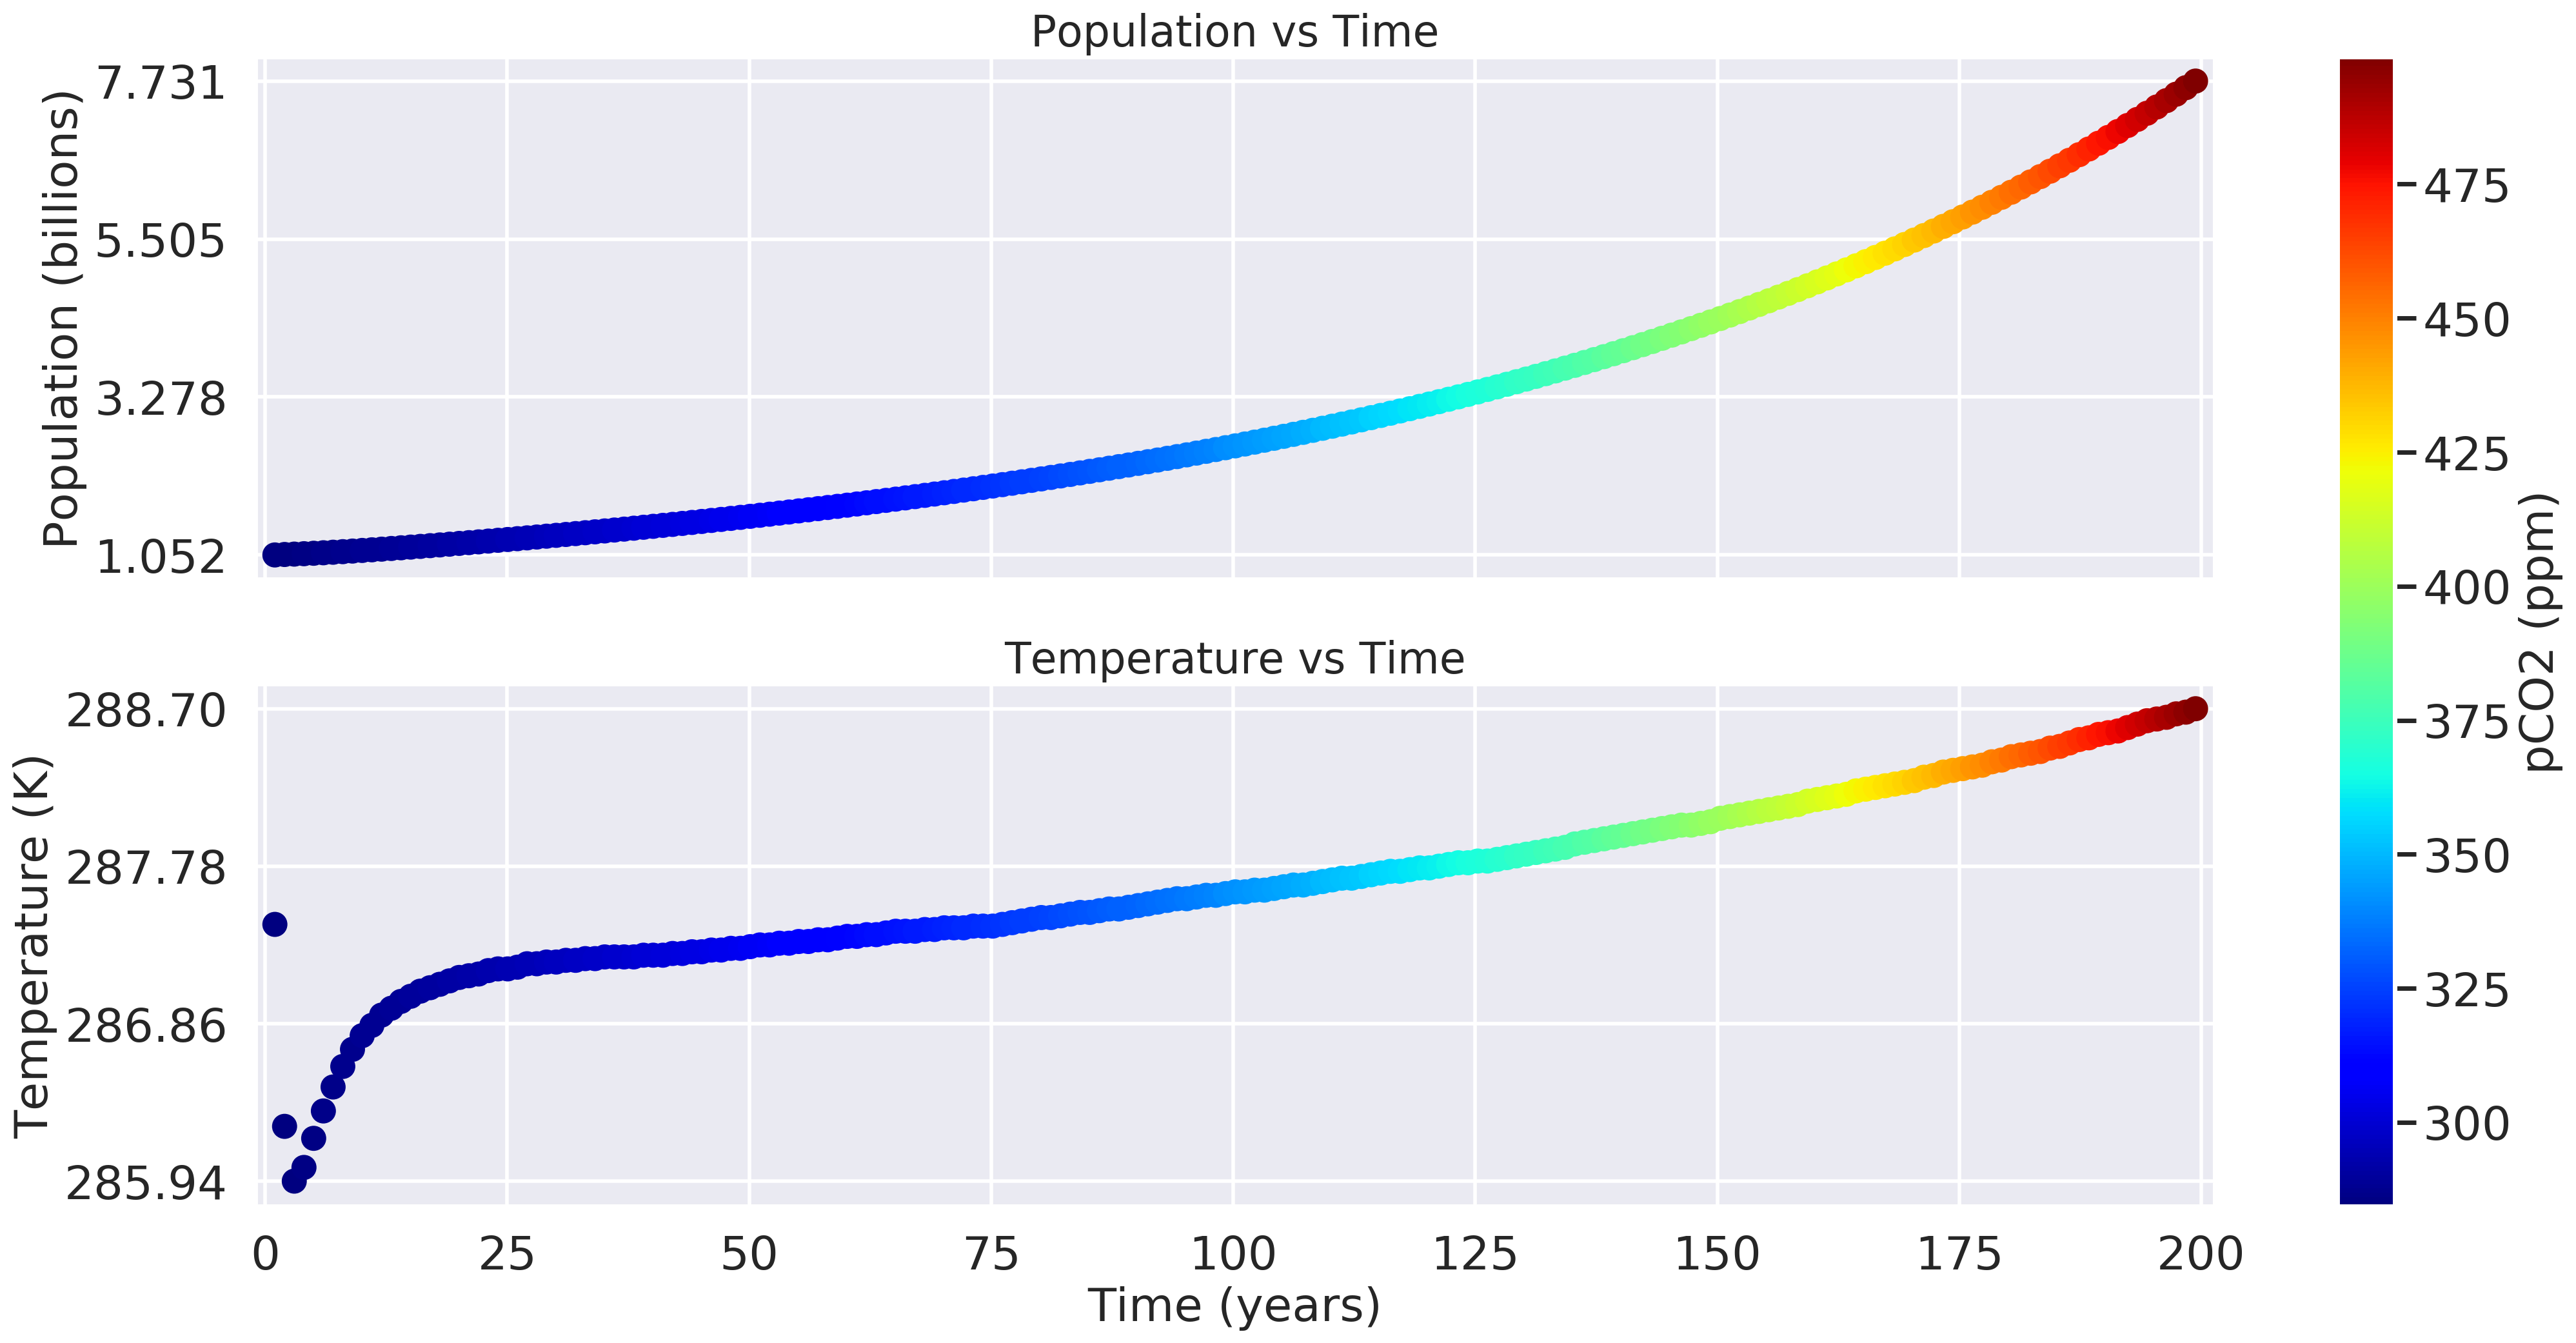

In [9]:
nameList = makeDefNamelist() #make namelist
nameList['ebm']['runTime'] = 200
nameList['ebm']['lverbose']=False #controls terminal output, used for debugging
#nameList['ebm']['N0']=7700
#nameList['ebm']['pco20']=4.4e-4
nameList['ebm']['En'] = 1


with tempfile.TemporaryDirectory() as dirpath:
    runFolder = newFolder(nameList,dirpath) #make the temporary folder

    df, finalavgtemp = readOutput() #read output into datframe
    
    os.chdir(notePath) 
    call("rm -rf tmp*", shell=True)#delete the temporary folder and unlink it's contents
    
    print('Final Temp(K): ' + str(finalavgtemp));
    print('')
    call("echo   ", shell=True)
    call("echo End of Python Notebook Reached",shell=True)
makePlots(df)